In [1]:
%run /workspace/FGindex/Utils/FGindex_function.ipynb
%run /workspace/FGindex/Utils/portfolio_metrics.ipynb
%run /workspace/FGindex/Utils/Backtesting_function.ipynb

In [ ]:
from pykrx import stock
from pykrx import bond

In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from operator import itemgetter
from datetime import date, datetime
import time
from collections import Counter

# Utils

In [2]:

# 각 세부항목별 이상치 플랏팅, 이상치 추출 
def plotting_Risk(ticker, standard, path, save_folder, thres= 1.96, log_transform=False, detect = "1"):
    
    if path == 'data_FGscore':
        fig, ax = plt.subplots(figsize=(13,3))
        stock = pd.read_csv("/workspace/FGindex/DATA/{}/{}.csv".format(path, ticker))
        stock.columns = ["index","datetime","close","FG_score"]
        stock = stock.sort_values("datetime").reset_index(drop=True)
        
    elif path == 'data_macro':
        fig, ax = plt.subplots(figsize=(13,3))
        stock = pd.read_csv("/workspace/FGindex/DATA/{}/{}.csv".format(path, i), header = None)
        stock.columns = ["datetime","close"]
        stock = stock.sort_values("datetime").reset_index(drop=True)        
    
    datetime_list = [datetime.strptime(i,"%Y-%m-%d").date() for i in stock.datetime]
    stock["datetime"] = datetime_list
        
    # data 소스 변경
    col_date = stock.datetime
    
    # log transformation 수행
    if log_transform==False:
        diff_data = list(stock.close)
    else:
        diff_data = list(np.log(stock.close))
    
    # data preprocessing
    if standard == 1:
        anomaly_date, anomaly_value = np.nan, np.nan
        
    # 로그변환, time diff, 변동성을 통한 이상치 확인
    elif standard == 'diff':
        # plot
        diff_data = [np.nan,] + list(np.diff(diff_data))
        calcul_res = [i for i in diff_data if (i!=-np.inf and i!=np.inf) ]
        std_data = np.nanstd(calcul_res)
        mean_data = np.nanmean(calcul_res)        
        pe1 = mean_data+std_data*thres
        pe2 = mean_data-std_data*thres
        ax.axhline(y=pe1,color='r',linestyle='--',label='nomal_bound')
        ax.axhline(y=pe2,color='r',linestyle='--')
        
        # anomaly
        anomaly_index = [(index,value) for index,value in enumerate(diff_data) if (value > pe1) or (value < pe2)]
        anomaly_date = [col_date[i[0]] for i in anomaly_index]
        anomaly_value = [i[1] for i in anomaly_index]
        ax.scatter(anomaly_date,anomaly_value,color='red')
        
    elif standard == 'smoothing':
        # plot
        rolling_diff = list(pd.Series(diff_data).rolling(window=48,min_periods=1,center = True).mean())
        res = list(np.array(diff_data) - np.array(rolling_diff))

        calcul_res = [i for i in res if (i!=-np.inf and i!=np.inf) ]
        diff_data = res
        std_data = np.nanstd(calcul_res)
        mean_data = np.nanmean(calcul_res)    
        
        
        pe1 = mean_data+std_data*thres
        pe2 = mean_data-std_data*thres
        ax.axhline(y=pe1,color='r',linestyle='--',label='nomal_bound')
        ax.axhline(y=pe2,color='r',linestyle='--')
        
        # anomaly
        anomaly_index = [(index,value) for index,value in enumerate(res) if (value > pe1) or (value < pe2)]
        anomaly_date = [col_date[i[0]] for i in anomaly_index]
        anomaly_value = [i[1] for i in anomaly_index]
        ax.scatter(anomaly_date,anomaly_value,color='red')

    ax.plot(col_date,diff_data,label=ticker)
    ax.legend(loc="upper left")
    ax.set_title(ticker)
    ax.set_xlim([np.min(col_date),np.max(col_date)])
    anomaly = anomaly_date
    anomaly_value = (anomaly_value - mean_data) / std_data
    
    max_date = np.max(stock.datetime)
    min_date = np.min(stock.datetime)
    
    return list(anomaly), list(anomaly_value), min_date, max_date
    

# Macro

In [3]:
macro_list = [
    "DFF","DTB3","DTB6","DGS1","DGS2","DGS3","DGS5","DGS7"
    ,"DGS10","DGS20","DGS30"
    ,"DAAA","DBAA"
    ,"TEDRATE"
    ,"T3MFF","T6MFF","T1YFF","T5YFF","T10YFF"
    ,"T10Y2Y","T10Y3M"
    ,"AAAFF","BAAFF"
    ,"AAA10Y","BAA10Y"]

## macro 금리 스프레드

/opt/conda/lib/python3.6/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning:

Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()

/opt/conda/lib/python3.6/site-packages/pandas/core/series.py:853: RuntimeWarning:

divide by zero encountered in log

/opt/conda/lib/python3.6/site-packages/pandas/core/series.py:853: RuntimeWarning:

invalid value encountered in log

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `f

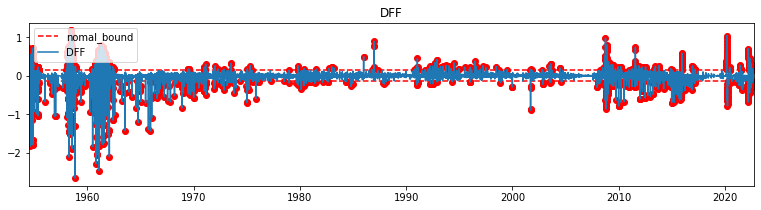

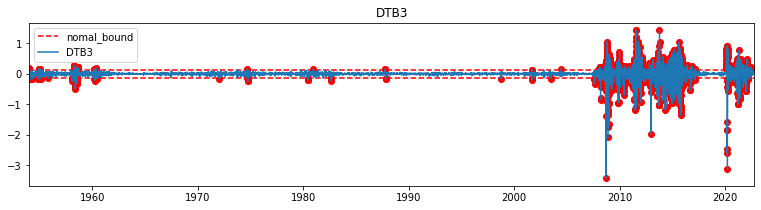

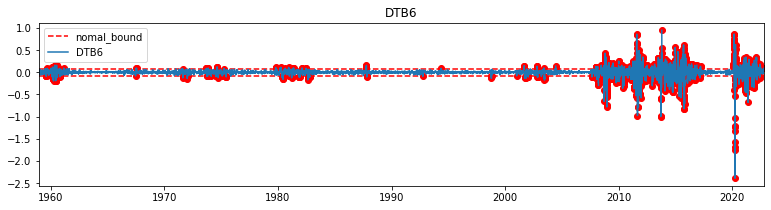

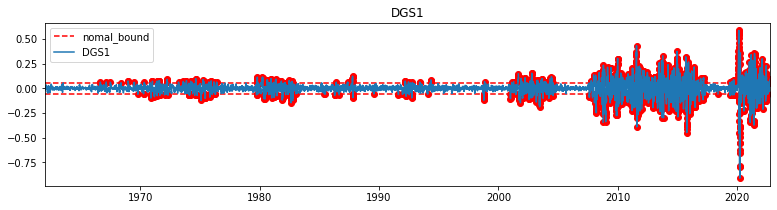

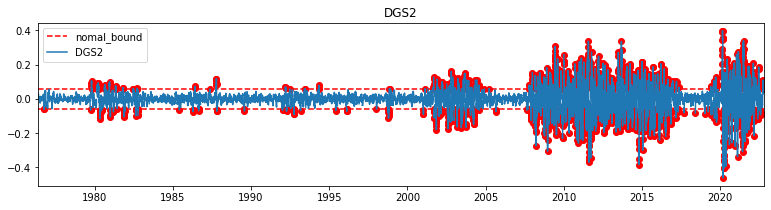

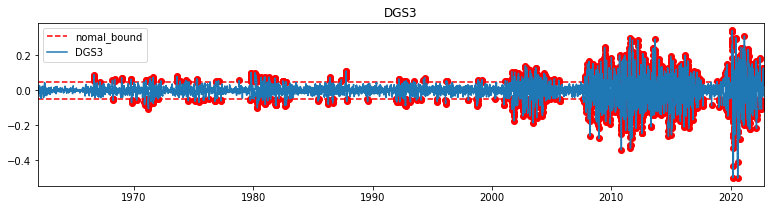

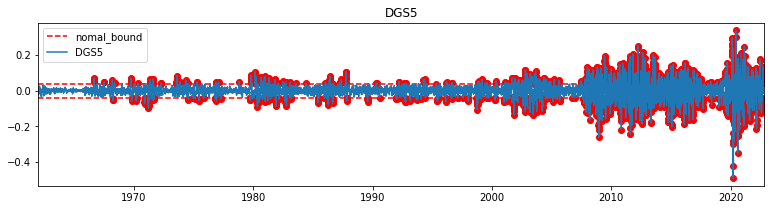

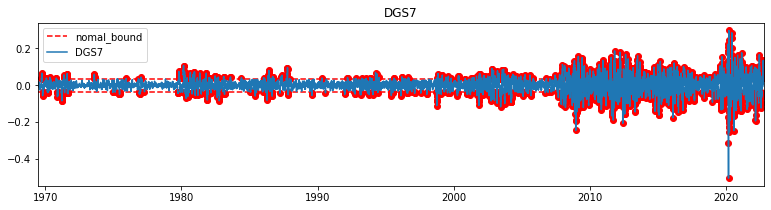

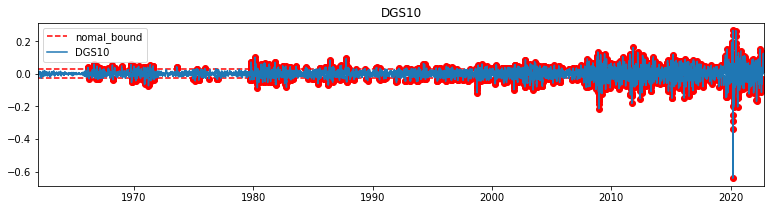

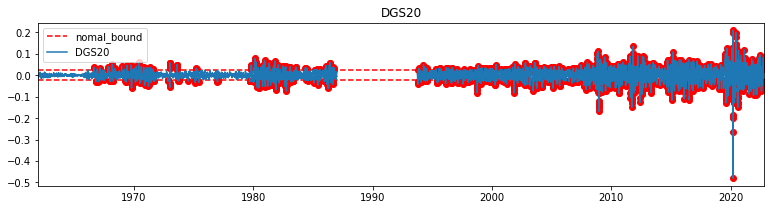

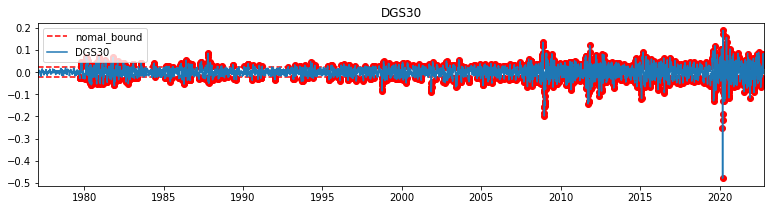

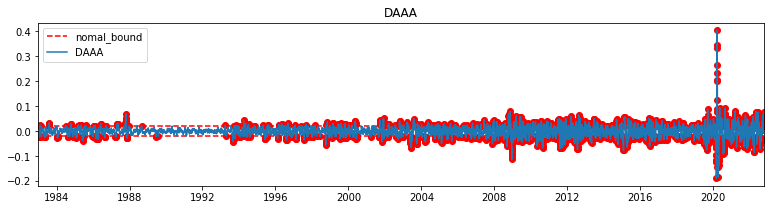

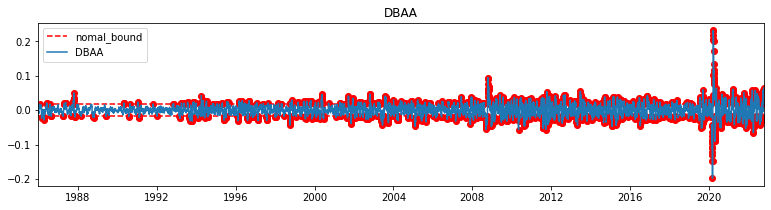

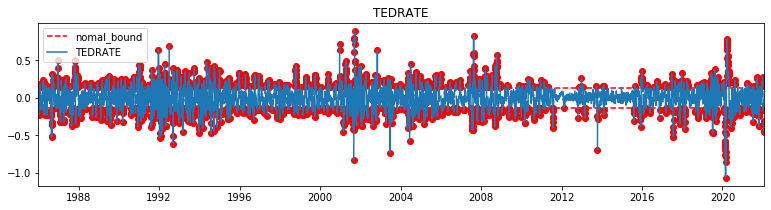

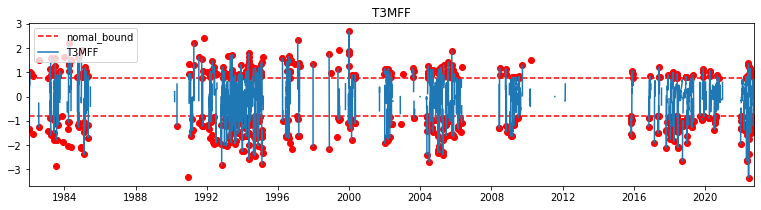

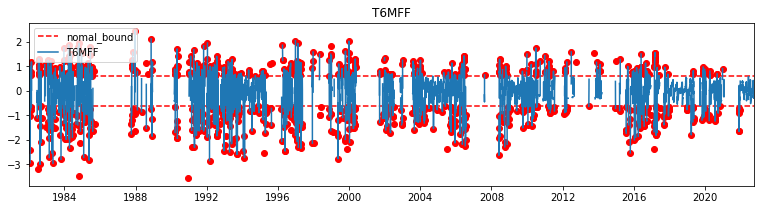

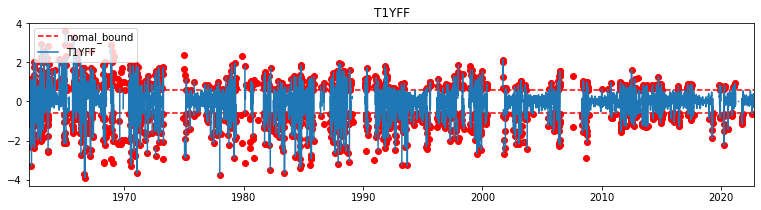

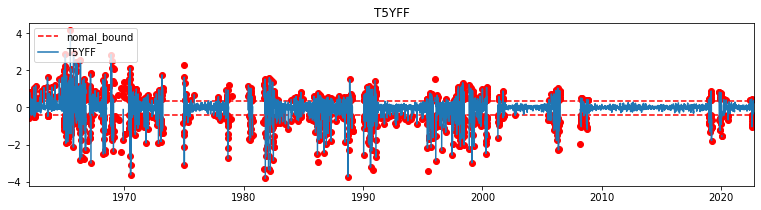

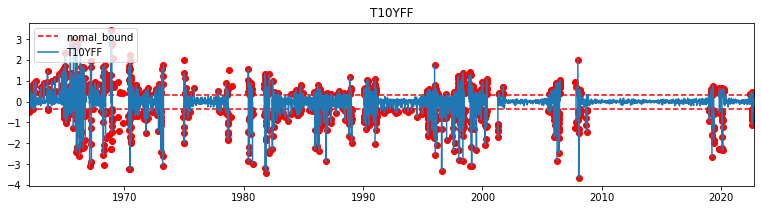

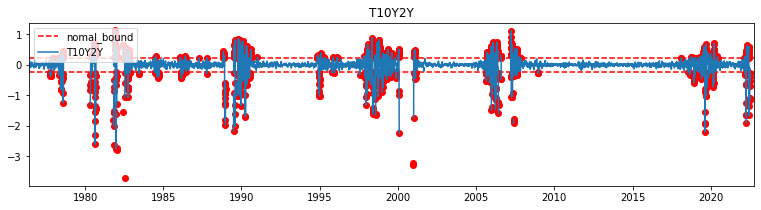

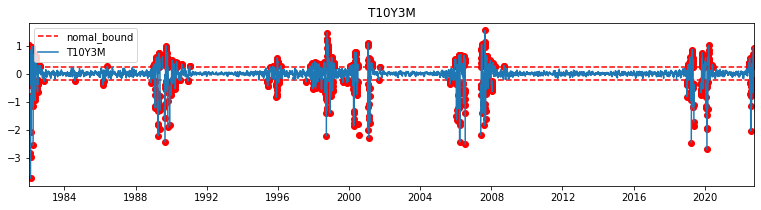

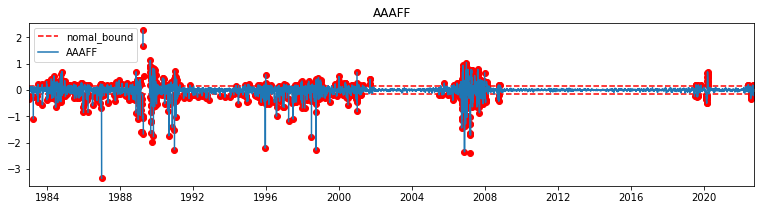

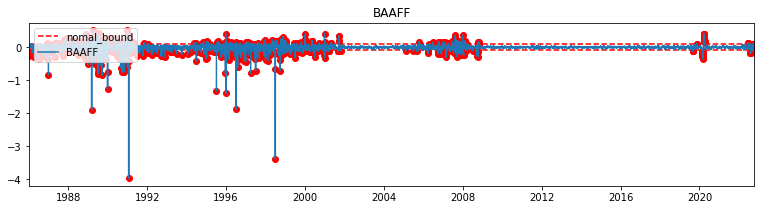

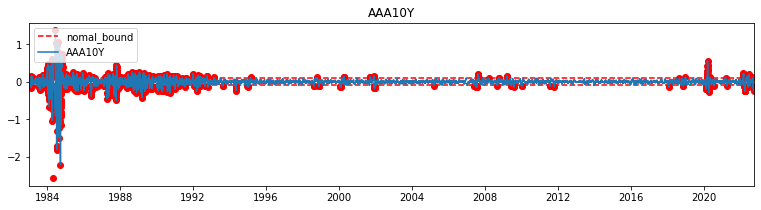

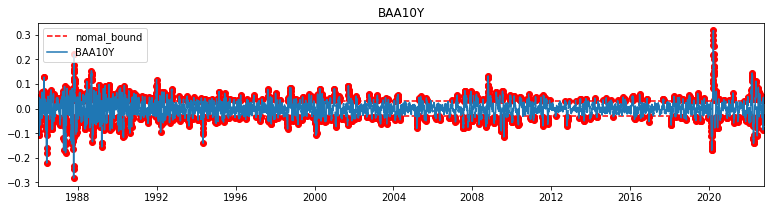

In [4]:
anomaly_date_list = []
anomaly_value_list = []
min_date_list = []
max_date_list = []
for i in macro_list:
    # data read
    anomaly_date,anomaly_value, min_date, max_date = plotting_Risk('{}'.format(i),
                                                                   'smoothing','data_macro'
                                                                   ,'macro_anomaly'
                                                                   ,thres= 1, log_transform=True)
    
    anomaly_date_list = anomaly_date_list + anomaly_date
    anomaly_value_list = anomaly_value_list + anomaly_value
    min_date_list.append(min_date)
    max_date_list.append(max_date)
    

In [5]:

macro_factor = pd.DataFrame(zip(anomaly_date_list,np.abs(anomaly_value_list)), columns = ["datetime","weight"])
macro_factor = macro_factor.groupby("datetime")["weight"].sum()
macro_factor = pd.DataFrame(macro_factor).reset_index()
macro_factor['weight'] = macro_factor['weight']/len(macro_list)


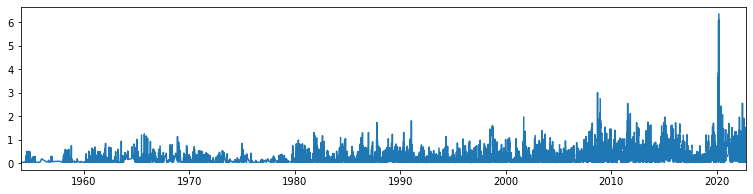

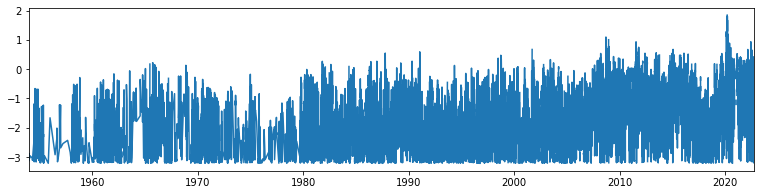

In [6]:

fig, ax = plt.subplots(figsize=(13,3))
ax.plot(macro_factor.datetime,macro_factor.weight)
ax.set_xlim([np.min(min_date_list),np.max(max_date_list)])
plt.show()

fig, ax = plt.subplots(figsize=(13,3))
ax.plot(macro_factor.datetime,np.log(macro_factor.weight))
ax.set_xlim([np.min(min_date_list),np.max(max_date_list)])
plt.show()


# Index prcessing

In [7]:
# stock_df = pd.read_csv("/workspace/FGindex/DATA/data_index/{}.csv".format('1001'))
# stock_df = stock_df[stock_df[stock_df['거래량']!=0].index[0]:].reset_index(drop=True)
# stock = stock_df

In [8]:
# print("preprocessing")
# stock = data_preprocessing(stock)

# datetime_list = stock['datetime']

# print("S1 score")
# Volatility_list = calcul_volatility(stock)
# Volume_list = calcul_volume(stock)
# S1_score = volatility_volume_score(Volatility_list, Volume_list)

# print("S2 score")
# S2_score = momentum_score(S1_score, stock)

# print("FG score")
# FG_score = calcul_FGscore(S1_score, S2_score)

# print("final_data")

# final_data = pd.DataFrame({'datetime': datetime_list[365:],
#                            'close': stock['close'][365:],
#                            'Volatility': Volatility_list,
#                            'Volume' : Volume_list[365:],
#                            'S1_score' : S1_score,
#                            'S2_score' : S2_score,
#                            'FG_score' : FG_score})
# final_data.to_csv("FG_score_step.csv")

In [9]:
index_processing = pd.read_csv("FG_score_step.csv")

In [10]:
datetime_list = [datetime.strptime(i,"%Y-%m-%d").date() for i in index_processing.datetime]
index_processing["datetime"] = datetime_list

# data check 

In [11]:
joined_data = index_processing.join(macro_factor.set_index('datetime'), on="datetime")
joined_data['weight'] = joined_data['weight'].fillna(0)

In [12]:
joined_data

,Unnamed: 0,datetime,close,Volatility,Volume,S1_score,S2_score,FG_score,weight
0,0,1981-04-06,110.30,-0.636290,0.847458,0.526396,0.521617,0.568216,0.000000
1,1,1981-04-07,109.60,-0.710551,0.212945,0.437799,0.413103,0.545091,0.000000
2,2,1981-04-08,111.00,-0.820908,0.616651,0.474468,0.568170,0.566989,0.000000
3,3,1981-04-09,110.80,-0.602984,0.780872,0.522236,0.480198,0.562368,0.000000
4,4,1981-04-10,112.00,-0.685709,0.987735,0.537753,0.602895,0.580350,0.000000
...,...,...,...,...,...,...,...,...,...
11065,11065,2022-10-04,2209.38,1.440329,-0.279631,0.645087,-0.653402,0.396158,0.258050
11066,11066,2022-10-05,2215.22,1.736580,0.411917,0.768562,-0.470572,0.410557,0.476983
11067,11067,2022-10-06,2237.86,1.597342,0.129667,0.715876,-0.328724,0.441439,0.668423
11068,11068,2022-10-07,2232.84,1.528223,-0.270976,0.657156,-0.386910,0.436775,0.831520


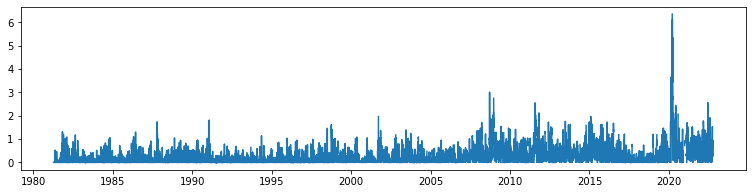

In [13]:
fig, ax = plt.subplots(figsize=(13,3))
ax.plot(joined_data.datetime,joined_data.weight)

In [14]:
def momentum_score(S1_list, value):
    
    short_alpha = [(i*9)+1 for i in S1_list]
    long_alpha = [10 - ((i*9)+1) for i in S1_list]
    
    # lambda
    lambda_30 = 1-(1/30)
    lambda_7 = 1-(1/7)
    
    # close ma
    close_mu30_list = []
    close_mu7_list = []
    for i in range(len(value)):

        # list set
        list1 = []
        list2 = []

        # sumation
        for j in range(i+1):
            close_mu_30 = (1-lambda_30) * (lambda_30**j) * value[i-j]
            close_mu_7 = (1-lambda_7) * (lambda_7**j) * value[i-j]
            list1.append(close_mu_30)
            list2.append(close_mu_7)

        V30 = np.sum(list1)
        V7 = np.sum(list2)
        close_mu30_list.append(V30)
        close_mu7_list.append(V7)
        
    X_short = (stock.close - close_mu7_list) / close_mu7_list
    X_long = (stock.close - close_mu30_list) / close_mu30_list
        
    products_short = [a * b for a, b in zip(short_alpha, X_short[365:])]
    products_long = [a * b for a, b in zip(long_alpha, X_long[365:])]
    product_momentum = [a+b for a,b in zip(products_short, products_long)]
    
    C = 16.387308
    S2_list = [(i*C)/10 for i in product_momentum]
    
    return S2_list

In [15]:
S1_list = joined_data.S1_score
value = joined_data.weight

In [16]:
value = [i if (i!=-np.inf and i!=np.inf) else 0 for i in value]
value = pd.DataFrame(value)[0]

In [17]:
len(S1_list)

11070

In [19]:
len(value)

11070

In [21]:

short_alpha = [(i*9)+1 for i in S1_list]
long_alpha = [10 - ((i*9)+1) for i in S1_list]

# lambda
lambda_30 = 1-(1/30)
lambda_7 = 1-(1/7)

# close ma
close_mu30_list = []
close_mu7_list = []
for i in range(len(value)):

    # list set
    list1 = []
    list2 = []

    # sumation
    for j in range(i+1):
        close_mu_30 = (1-lambda_30) * (lambda_30**j) * value[i-j]
        close_mu_7 = (1-lambda_7) * (lambda_7**j) * value[i-j]
        list1.append(close_mu_30)
        list2.append(close_mu_7)

    V30 = np.sum(list1)
    V7 = np.sum(list2)
    close_mu30_list.append(V30)
    close_mu7_list.append(V7)

X_short = (value - close_mu7_list) / close_mu7_list
X_long = (value - close_mu30_list) / close_mu30_list

products_short = [a * b for a, b in zip(short_alpha,  X_short)]
products_long = [a * b for a, b in zip(long_alpha, X_long)]
product_momentum = [a+b for a,b in zip(products_short, products_long)]

C = 16.387308
S2_list = [(i*C)/10 for i in product_momentum]


In [146]:
products_short = [a * b for a, b in zip(short_alpha,  X_short)]
products_long = [a * b for a, b in zip(long_alpha, X_long)]
product_momentum = [a+b for a,b in zip(products_short, products_long)]

In [160]:
product_momentum

[nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 133.82335356027517,
 78.34509738575875,
 28.306839461632315,
 11.358823542377895,
 -10.0,
 52.41791553840794,
 36.50798360967268,
 10.895563077345777,
 -5.810166006020215,
 -10.0,
 -10.0,
 -5.100939972539038,
 -4.638034489737633,
 1.852503383252385,
 -4.884422838355956,
 -10.0,
 -10.0,
 -10.0,
 -1.6041516907675784,
 -10.0,
 -10.0,
 -10.0,
 -10.0,
 -10.0,
 -10.0,
 -10.0,
 -10.0,
 24.570443682147115,
 9.34260167011877,
 16.049541824395533,
 11.457433603313167,
 4.045046078366948,
 -10.0,
 36.99153380626138,
 22.671092832566586,
 6.6020547527528235,
 -10.0,
 -10.0,
 -10.0,
 -0.8741990853873254,
 -10.0,
 -4.506524909925984,
 -10.0,
 -10.0,
 -10.0,
 -10.0,
 -10.0,
 -10.0,
 -10.0,
 -10.0,
 -10.0,
 -10.0,
 -10.0,
 -10.0,
 -10.0,
 -10.0,
 -10.0,
 -10.0,
 -10.0,
 -10.0,
 -10.0,
 -10.0,
 -10.0,
 -10.0,
 29.14468646699551,
 -10.0,
 -10.0,
 -10.0,
 -10.0,

In [148]:

C = 16.387308
S2_list = [(i*C)/10 for i in product_momentum]

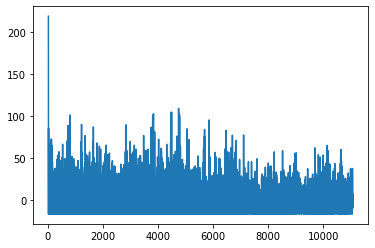

In [151]:
plt.plot(S2_list)

In [141]:
close_mu7_list

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0426938399281202,
 0.10461260442827522,
 0.12527409750395613,
 0.1278160842011591,
 0.10955664360099351,
 0.16730589308223948,
 0.218531558836894,
 0.22509313873460407,
 0.20044051064111107,
 0.17180615197809518,
 0.14726241598122447,
 0.13281290261578152,
 0.12088039778354746,
 0.11900750344124805,
 0.10822276040997421,
 0.09276236606569219,
 0.07951059948487903,
 0.0681519424156106,
 0.06609357296653663,
 0.05665163397131711,
 0.0485585434039861,
 0.04162160863198809,
 0.03567566454170408,
 0.030579141035746354,
 0.02621069231635402,
 0.02246630769973202,
 0.019256835171198874,
 0.03694773108659177,
 0.044508845980843925,
 0.05970268621728262,
 0.07157237102552472,
 0.07528104999806243,
 0.06452661428405351,
 0.12071335578473605,
 0.16196647668382105,
 0.1694898441896765,
 0.145277009305437,
 0.1245231508332317,
 0.10673412928562717,
 0.10

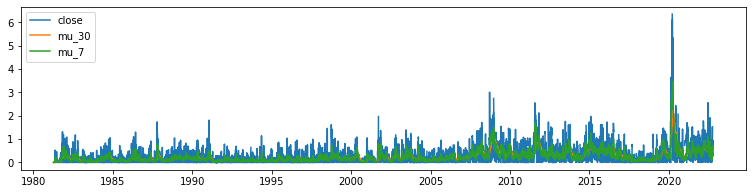

In [127]:
fig, ax = plt.subplots(figsize=(13,3))
ax.plot(joined_data.datetime,joined_data.weight,
         joined_data.datetime,close_mu30_list,
         joined_data.datetime,close_mu7_list)

ax.legend(["close","mu_30", "mu_7"])
plt.show()


In [134]:
len(close_mu7_list)

11070

In [165]:
product_momentum

[nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 133.82335356027517,
 78.34509738575875,
 28.306839461632315,
 11.358823542377895,
 -10.0,
 52.41791553840794,
 36.50798360967268,
 10.895563077345777,
 -5.810166006020215,
 -10.0,
 -10.0,
 -5.100939972539038,
 -4.638034489737633,
 1.852503383252385,
 -4.884422838355956,
 -10.0,
 -10.0,
 -10.0,
 -1.6041516907675784,
 -10.0,
 -10.0,
 -10.0,
 -10.0,
 -10.0,
 -10.0,
 -10.0,
 -10.0,
 24.570443682147115,
 9.34260167011877,
 16.049541824395533,
 11.457433603313167,
 4.045046078366948,
 -10.0,
 36.99153380626138,
 22.671092832566586,
 6.6020547527528235,
 -10.0,
 -10.0,
 -10.0,
 -0.8741990853873254,
 -10.0,
 -4.506524909925984,
 -10.0,
 -10.0,
 -10.0,
 -10.0,
 -10.0,
 -10.0,
 -10.0,
 -10.0,
 -10.0,
 -10.0,
 -10.0,
 -10.0,
 -10.0,
 -10.0,
 -10.0,
 -10.0,
 -10.0,
 -10.0,
 -10.0,
 -10.0,
 -10.0,
 -10.0,
 29.14468646699551,
 -10.0,
 -10.0,
 -10.0,
 -10.0,

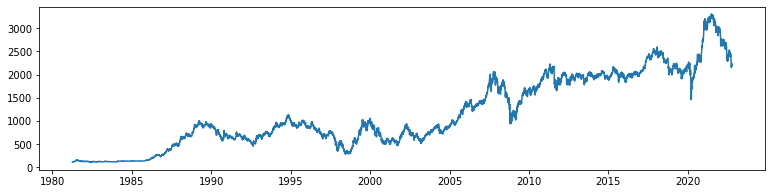

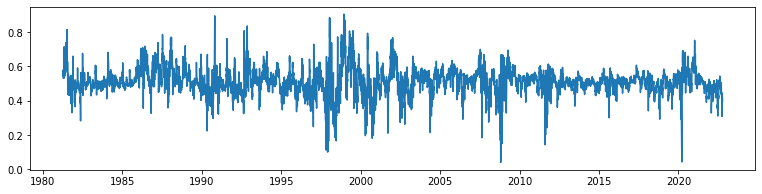

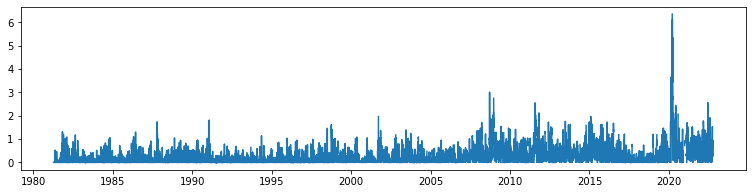

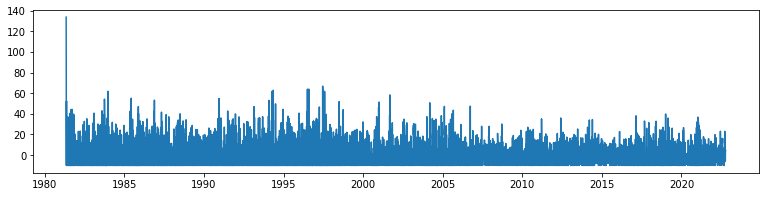

In [163]:
fig, ax = plt.subplots(figsize=(13,3))
ax.plot(joined_data.datetime,joined_data.close)

fig, ax = plt.subplots(figsize=(13,3))
ax.plot(joined_data.datetime,joined_data.FG_score)

fig, ax = plt.subplots(figsize=(13,3))
ax.plot(joined_data.datetime,joined_data.weight)

fig, ax = plt.subplots(figsize=(13,3))
ax.plot(joined_data.datetime,product_momentum)

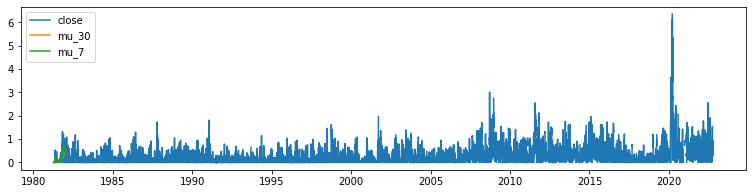

In [86]:
fig, ax = plt.subplots(figsize=(13,3))
ax.plot(joined_data.datetime,joined_data.weight,
         joined_data.datetime,close_mu30_list,
         joined_data.datetime,close_mu7_list)

ax.legend(["close","mu_30", "mu_7"])
plt.show()


In [84]:
len(close_mu7_list)

11070

In [62]:
tmp = momentum_score(joined_data.S1_score, joined_data.weight)

In [66]:
tmp

,datetime,close,Volatility,Volume,S1_score,S2_score,FG_score
0,1981-04-06,110.30,-0.636290,0.847458,0.526396,0.521617,0.568216
1,1981-04-07,109.60,-0.710551,0.212945,0.437799,0.413103,0.545091
2,1981-04-08,111.00,-0.820908,0.616651,0.474468,0.568170,0.566989
3,1981-04-09,110.80,-0.602984,0.780872,0.522236,0.480198,0.562368
4,1981-04-10,112.00,-0.685709,0.987735,0.537753,0.602895,0.580350
...,...,...,...,...,...,...,...
11065,2022-10-04,2209.38,1.440329,-0.279631,0.645087,-0.653402,0.396158
11066,2022-10-05,2215.22,1.736580,0.411917,0.768562,-0.470572,0.410557
11067,2022-10-06,2237.86,1.597342,0.129667,0.715876,-0.328724,0.441439
11068,2022-10-07,2232.84,1.528223,-0.270976,0.657156,-0.386910,0.436775


/opt/conda/lib/python3.6/site-packages/pandas/core/series.py:853: RuntimeWarning:

divide by zero encountered in log



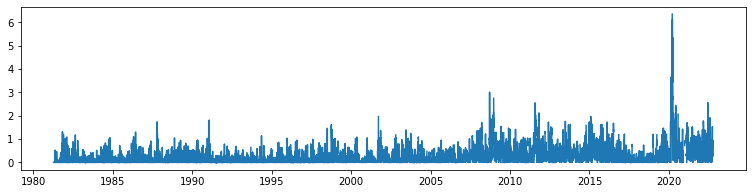

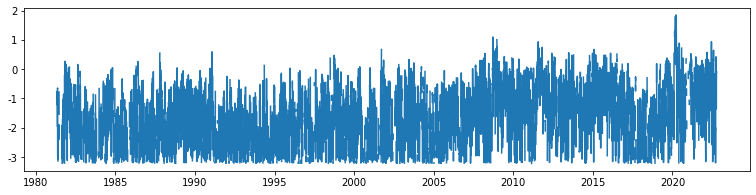

In [19]:
# fig, ax = plt.subplots(figsize=(13,3))
# ax.plot(joined_data.datetime,S1_score)

# fig, ax = plt.subplots(figsize=(13,3))
# ax.plot(joined_data.datetime,S2_score)

fig, ax = plt.subplots(figsize=(13,3))
ax.plot(joined_data.datetime,joined_data.weight)


fig, ax = plt.subplots(figsize=(13,3))
ax.plot(joined_data.datetime,np.log(joined_data.weight))

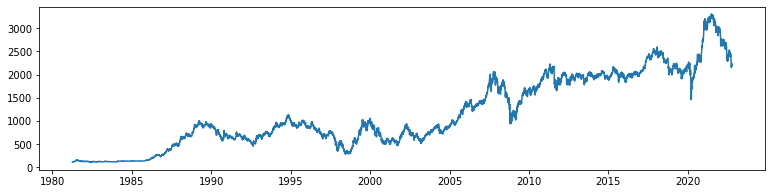

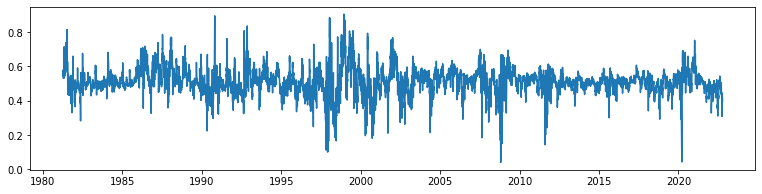

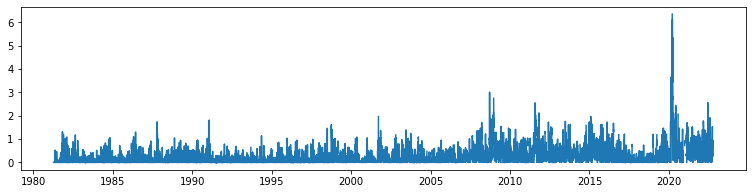

In [27]:
fig, ax = plt.subplots(figsize=(13,3))
ax.plot(joined_data.datetime,joined_data.close)

fig, ax = plt.subplots(figsize=(13,3))
ax.plot(joined_data.datetime,joined_data.FG_score)

fig, ax = plt.subplots(figsize=(13,3))
ax.plot(joined_data.datetime,joined_data.weight)

In [ ]:
fig = make_subplots(specs = [[{'secondary_y':True}]])
fig.add_trace(
    go.Scatter(x=final_data.date, y = final_data.close, name = "close"
               , hovertemplate = 'date = %{x}<br>'+
                                 'value = %{y}')
)
fig.add_trace(
    go.Scatter(x=final_data.date, y = final_data.FG_score, name = "FG"
               , hovertemplate = 'date = %{x}<br>'+
                                 'value = %{y}'),
    secondary_y = True,
)

# fig.update_layout(
#     title_text = "FG score", hovermode="x")
fig.update_xaxes(title_text = "date", rangeslider_visible = True)
fig.update_yaxes(title_text = "FG_score", secondary_y = True)
fig.update_yaxes(title_text = "stock_close", secondary_y = False)
# specific line

fig.show()

In [ ]:
def momentum_score(S1_list, stock):
    
    short_alpha = [(i*9)+1 for i in S1_list]
    long_alpha = [10 - ((i*9)+1) for i in S1_list]
    
    # lambda
    lambda_30 = 1-(1/30)
    lambda_7 = 1-(1/7)
    
    # close ma
    close_mu30_list = []
    close_mu7_list = []
    for i in range(len(stock.close)):

        # list set
        list1 = []
        list2 = []

        # sumation
        for j in range(i+1):
            close_mu_30 = (1-lambda_30) * (lambda_30**j) * stock.close[i-j]
            close_mu_7 = (1-lambda_7) * (lambda_7**j) * stock.close[i-j]
            list1.append(close_mu_30)
            list2.append(close_mu_7)

        V30 = np.sum(list1)
        V7 = np.sum(list2)
        close_mu30_list.append(V30)
        close_mu7_list.append(V7)
        
    X_short = (stock.close - close_mu7_list) / close_mu7_list
    X_long = (stock.close - close_mu30_list) / close_mu30_list
        
    products_short = [a * b for a, b in zip(short_alpha, X_short[365:])]
    products_long = [a * b for a, b in zip(long_alpha, X_long[365:])]
    product_momentum = [a+b for a,b in zip(products_short, products_long)]
    
    C = 16.387308
    S2_list = [(i*C)/10 for i in product_momentum]
    
    return S2_list